In [1]:
import numpy as np
from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient, OperatorStateFn
from qiskit.utils import QuantumInstance
import matplotlib.pyplot as plt
import sys, os
sys.path.insert(0, os.path.join("..", "..","src"))
from qiskit_utils import BinaryObjectiveFunction
from data_utils import circle, plot_data, generate_ds

# Set a random seed
np.random.seed(42)

In [2]:
# Generate training and test data
num_training = 200
num_test = 2000

X_train, y_train, new_y_train = generate_ds(num_training)
X_test, y_test, new_y_test= generate_ds(num_test)

In [3]:
# set method to calculcate expected values
expval = AerPauliExpectation()

# define gradient method
gradient = Gradient()

# define quantum instances (statevector and sample based)
qi_sv = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

In [4]:
from qiskit_machine_learning.neural_networks import OpflowQNN

In [5]:
inputs = ParameterVector('input', length=3) # 1 extra for label
# inputs = ParameterVector('input', length=3)
weights = ParameterVector('weight', length=8)

# 1qubit classifier
qc1 = QuantumCircuit(1)
qc1.u(weights[5],weights[6],weights[7],0)
qc1.rz(inputs[0]*weights[0]+inputs[1]*weights[1]+inputs[2]*weights[2] + weights[3],0)
qc1.ry(weights[4],0)

qc_sfn1 = StateFn(qc1)

H1 = StateFn(PauliSumOp.from_list([('Z', 1.0)]))  
H2 = StateFn(PauliSumOp.from_list([('Z', -1.0)]))  

op1 = ~H1 @ (qc_sfn1)
op2 = ~H2 @ (qc_sfn1)
print(op1)
print(len(weights))

ComposedOp([
  OperatorMeasurement(1.0 * Z),
  CircuitStateFn(
       ┌──────────────────────────────────┐»
  q_0: ┤ U(weight[5],weight[6],weight[7]) ├»
       └──────────────────────────────────┘»
  «     ┌──────────────────────────────────────────────────────────────────────────────┐»
  «q_0: ┤ Rz(input[0]*weight[0] + input[1]*weight[1] + input[2]*weight[2] + weight[3]) ├»
  «     └──────────────────────────────────────────────────────────────────────────────┘»
  «     ┌───────────────┐
  «q_0: ┤ Ry(weight[4]) ├
  «     └───────────────┘
  )
])
8


In [6]:
# construct OpflowQNN with the operator, the input parameters, the weight parameters,
# the expected value, gradient, and quantum instance.
qnn1 = OpflowQNN(op1, inputs, weights, expval, gradient, qi_sv, input_gradients=True)
qnn2 = OpflowQNN(op2, inputs, weights, expval, gradient, qi_sv, input_gradients=True)

In [7]:
from qiskit.algorithms.optimizers import ADAM, L_BFGS_B
from qiskit_machine_learning.utils.loss_functions import L2Loss
from qiskit.utils import algorithm_globals

losses = []
def callback_fn(avg_loss, weights):
    print("weights: ", weights)
    print("loss: ", avg_loss)
    losses.append(avg_loss)

function = BinaryObjectiveFunction(X_train, new_y_train, qnn1, qnn2, L2Loss(), callback_fn)

In [ ]:
losses = []
# optimizer = ADAM(maxiter=30, lr=0.8)
optimizer = L_BFGS_B(maxiter=50)
# fit_result = optimizer.minimize(
fit_result = optimizer.optimize(
    num_vars=qnn1.num_weights,
    objective_function=function.objective,
    initial_point=algorithm_globals.random.random(qnn1.num_weights),
    gradient_function=function.gradient,
)

In [ ]:
plt.plot(losses)
print(len(losses))

In [8]:
ws = [-0.10763436,  2.79721208,  0.02107791,  1.46038244,  4.30106147,
       -1.15946883,  1.43257313,  0.34369468]

from test_utils import get_metrics
y_predict, y_tensor, accuracy, [tp, tn, fp, fn] = get_metrics(X_train, qnn1, ws)

Accuracy:  0.705
tp:  70 tn:  71  fp:  29  fn:  30


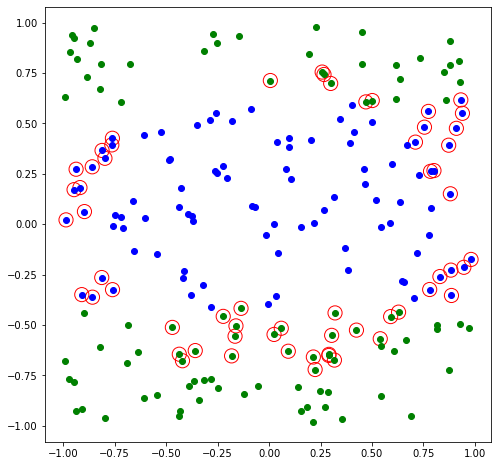

In [9]:
# print('Accuracy:', acc/len(y_tensor))
plt.figure(figsize=(8,8))
for x, y_target, y_ in zip(X_train, y_tensor, y_predict):
    if y_ == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=1)
plt.show()

In [10]:
y_predict, y_tensor, accuracy, [tp, tn, fp, fn] = get_metrics(X_test, qnn1, ws)

Accuracy:  0.7375
tp:  735 tn:  740  fp:  268  fn:  257


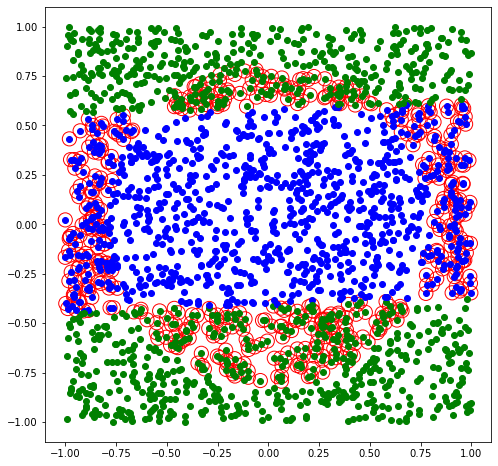

In [11]:
# print('Accuracy:', acc/len(y_tensor))
plt.figure(figsize=(8,8))
for x, y_target, y_ in zip(X_test, y_tensor, y_predict):
    if y_ == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=1)
plt.show()

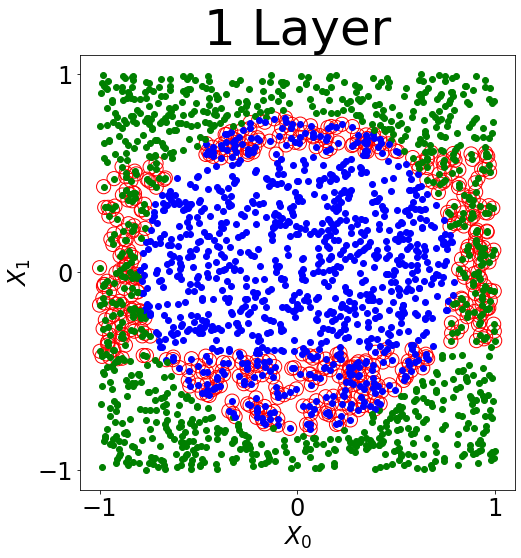

In [13]:
from matplotlib.ticker import MaxNLocator

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

# plot_data(Xdata, y_train, fig=fig, ax=axes[0])
for x, y_target, y_ in zip(X_test, y_tensor, y_predict):
    if y_target == 1:
        axes.plot(x[0], x[1], 'bo')
    else:
        axes.plot(x[0], x[1], 'go')
    if y_target != y_:
        axes.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=1)
        
axes.set_title('1 Layer', fontsize = 50)

axes.xaxis.set_major_locator(MaxNLocator(nbins=2))
axes.yaxis.set_major_locator(MaxNLocator(nbins=2))

axes.tick_params(labelsize=24)
axes.set_box_aspect(1)
axes.set_xlabel("$X_{0}$", fontsize=24)
axes.set_ylabel("$X_{1}$", fontsize=24)

# fig.tight_layout(pad=3.0)
plt.show()